In [0]:
from time import time
from multiprocessing import cpu_count

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
# GPU configuration
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Get MNIST data inside a DataLoader

In [0]:
class Dataset(data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index]

In [0]:
# Get MNIST pictures as Torch dataloader
(mnist_data, _), (_, _) = mnist.load_data() # We only care about images
mnist_data = mnist_data / 127.5 - 1. # Rescale -1 to 1
mnist_data = np.expand_dims(mnist_data, axis=3) # Add a channel dimension
mnist_dataset = Dataset(mnist_data)
mnist_dataloader = data.DataLoader(mnist_dataset, batch_size=100, 
                                   shuffle=True, num_workers=cpu_count())

# Classical GAN

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2,
                 output_size, output_shape):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size_1)
        self.map2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.map3 = nn.Linear(hidden_size_2, output_size)

        self.f = nn.LeakyReLU(negative_slope=0.2)
        self.output_shape = output_shape

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        x = torch.tanh(self.map3(x))
        return torch.reshape(x, (-1,)+self.output_shape)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size_1)
        self.map2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.map3 = nn.Linear(hidden_size_2, 1)
        self.f = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.f(self.map1(x))
        x = F.dropout(x, 0.3)
        x = self.f(self.map2(x))
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.map3(x))

In [0]:
class GAN():
    
    def __init__(self, dataloader, gen_params, disc_params, z_dim):

        self.dataloader = dataloader

        # default parameters for mnist 
        self.img_rows = dataloader.dataset[0].shape[0]
        self.img_cols = dataloader.dataset[0].shape[1]
        self.img_channels = dataloader.dataset[0].shape[2]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.z_dim = z_dim
        
        self.generator = Generator(*gen_params).to(device)
        self.discriminator = Discriminator(*disc_params).to(device)
        
    def sample_data(self, n_sample=100):
        z_random = np.random.randn(n_sample, self.z_dim)
        z_random = torch.FloatTensor(z_random).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu().numpy()
        return samples
        
    def train(self, epochs=1000, print_interval=1):
        
        criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
        d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0001)
        g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0001)
        d_steps = 1
        g_steps = 1
        
        for epoch in range(epochs):
            
            t=time()
            
            for batch in self.dataloader:
                batch = batch.type(torch.FloatTensor).to(device)
                for d_index in range(d_steps):
                    # 1. Train D on real+fake
                    self.discriminator.zero_grad()
        
                    #  1A: Train D on real
                    d_real_data = batch
                    d_real_decision = self.discriminator(d_real_data)
                    d_real_error = criterion(torch.min(d_real_decision, (1. - 1e-8) * torch.ones(d_real_decision.size()).to(device)),
                                             torch.ones((batch.shape[0], 1)).to(device))  # ones = true
                    d_real_error.backward() # compute/store gradients, but don't change params
        
                    #  1B: Train D on fake
                    d_gen_input = torch.FloatTensor(np.random.randn(batch.shape[0], self.z_dim)).to(device)
                    d_fake_data = self.generator(d_gen_input).detach()  # detach to avoid training G on these labels
                    d_fake_decision = self.discriminator(d_fake_data)
                    d_fake_error = criterion(torch.max(d_fake_decision, 1e-8 * torch.ones(d_fake_decision.size()).to(device)),
                                             torch.zeros((batch.shape[0], 1)).to(device))  # zeros = fake
                    d_fake_error.backward()
                    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
                for g_index in range(g_steps):
                    # 2. Train G on D's response (but DO NOT train D on these labels)
                    self.generator.zero_grad()
        
                    gen_input = torch.FloatTensor(np.random.randn(batch.shape[0], 
                                                                  self.z_dim)).to(device)
                    g_fake_data = self.generator(gen_input)
                    dg_fake_decision = self.discriminator(g_fake_data)
                    g_error = torch.mean(torch.log(1-dg_fake_decision))  # Train G to pretend it's genuine
        
                    g_error.backward()
                    g_optimizer.step()  # Only optimizes G's parameters
                    
    
            if epoch % print_interval == 0:
                dre, dfe = d_real_error.detach().cpu().numpy(), d_fake_error.detach().cpu().numpy()
                ge = g_error.detach().cpu().numpy()
                print("Epoch %s: D (%s real_err, %s fake_err) G (%s err);  time (%s)" %
                      (epoch, dre, dfe, ge, time()-t))
                
            if epoch % (print_interval*5) == 0:
                samples = self.sample_data(3)*0.5 + 0.5
                for img in samples:
                    plt.figure()
                    plt.imshow(img[:,:,0], cmap='gray')
                    plt.show()

In [0]:
img_shape = mnist_data[0].shape
img_size = img_shape[0] * img_shape[1] * img_shape[2]

z_dim = 32

gen_params = (z_dim, 256, 512, img_size, img_shape)
disc_params = (img_size, 512, 256)

In [0]:
gan = GAN(mnist_dataloader, gen_params, disc_params, z_dim=z_dim)

Epoch 0: D (0.0067590903 real_err, 0.015084852 fake_err) G (-0.017374761 err);  time (4.496970891952515)


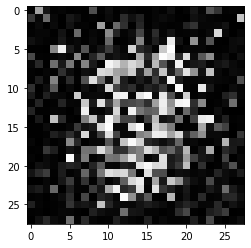

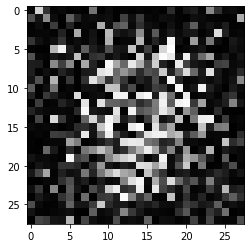

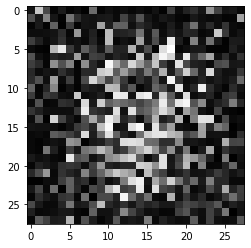

Epoch 1: D (0.17529115 real_err, 0.06305181 fake_err) G (-0.07809494 err);  time (4.337031602859497)
Epoch 2: D (0.13619941 real_err, 0.15255632 fake_err) G (-0.08665352 err);  time (4.374081134796143)
Epoch 3: D (0.01774451 real_err, 0.021479094 fake_err) G (-0.03677646 err);  time (4.348188400268555)
Epoch 4: D (0.01816546 real_err, 0.01925239 fake_err) G (-0.016467145 err);  time (4.343920946121216)
Epoch 5: D (0.2795209 real_err, 0.25621134 fake_err) G (-0.26077908 err);  time (4.366079807281494)


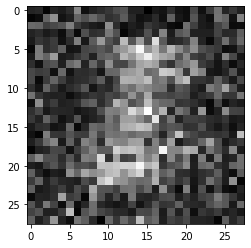

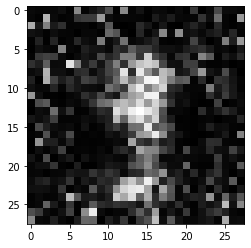

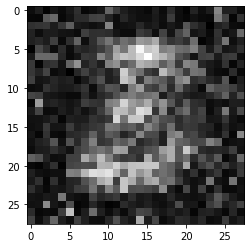

Epoch 6: D (0.17698058 real_err, 0.16874518 fake_err) G (-0.11409702 err);  time (4.347118854522705)
Epoch 7: D (0.21651523 real_err, 0.26993123 fake_err) G (-0.15927579 err);  time (4.37719988822937)
Epoch 8: D (0.22379443 real_err, 0.021470848 fake_err) G (-0.025330761 err);  time (4.367667198181152)
Epoch 9: D (0.066896096 real_err, 0.1381286 fake_err) G (-0.058225375 err);  time (4.435305118560791)
Epoch 10: D (0.24816611 real_err, 0.09304366 fake_err) G (-0.08163267 err);  time (4.440227270126343)


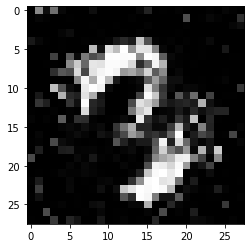

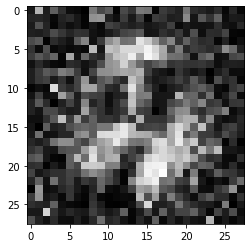

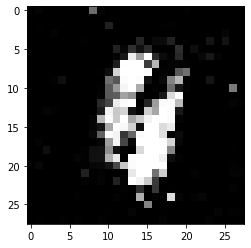

Epoch 11: D (0.26329088 real_err, 0.1492491 fake_err) G (-0.13794741 err);  time (4.403239965438843)
Epoch 12: D (0.10211715 real_err, 0.24593765 fake_err) G (-0.1703128 err);  time (4.387480735778809)
Epoch 13: D (0.31458968 real_err, 0.13790654 fake_err) G (-0.13111147 err);  time (4.360382795333862)
Epoch 14: D (0.22392839 real_err, 0.23522528 fake_err) G (-0.05231218 err);  time (4.37103533744812)
Epoch 15: D (0.16959837 real_err, 0.103601165 fake_err) G (-0.16282745 err);  time (4.334955453872681)


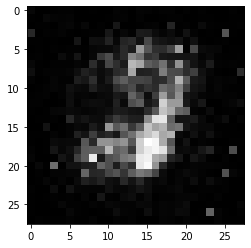

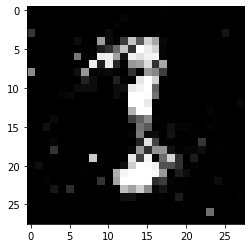

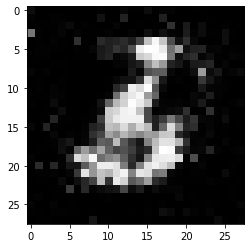

Epoch 16: D (0.33758694 real_err, 0.19366604 fake_err) G (-0.14935127 err);  time (4.379472017288208)
Epoch 17: D (0.28848407 real_err, 0.23886865 fake_err) G (-0.29815787 err);  time (4.35718297958374)
Epoch 18: D (0.1774498 real_err, 0.28090054 fake_err) G (-0.20757052 err);  time (4.376168966293335)
Epoch 19: D (0.32060453 real_err, 0.15882553 fake_err) G (-0.18102954 err);  time (4.3741295337677)
Epoch 20: D (0.25443414 real_err, 0.29002196 fake_err) G (-0.3212297 err);  time (4.350773334503174)


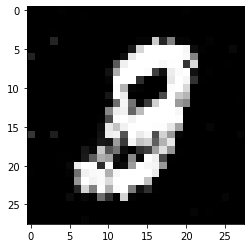

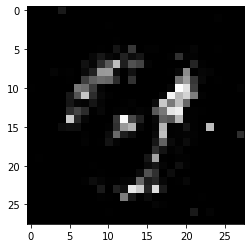

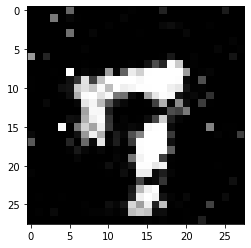

Epoch 21: D (0.20117067 real_err, 0.22254837 fake_err) G (-0.28353506 err);  time (4.400821208953857)
Epoch 22: D (0.28382593 real_err, 0.21872234 fake_err) G (-0.30603966 err);  time (4.358637571334839)
Epoch 23: D (0.298706 real_err, 0.1260937 fake_err) G (-0.2868446 err);  time (4.378761291503906)
Epoch 24: D (0.33080557 real_err, 0.24031165 fake_err) G (-0.224734 err);  time (4.3686792850494385)
Epoch 25: D (0.19548042 real_err, 0.47355932 fake_err) G (-0.19079746 err);  time (4.361917972564697)


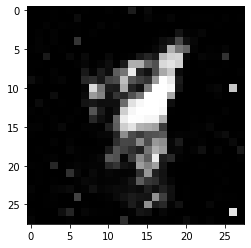

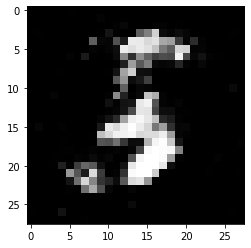

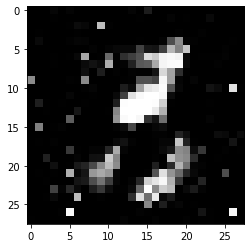

Epoch 26: D (0.39517245 real_err, 0.24995242 fake_err) G (-0.29346442 err);  time (4.350589275360107)
Epoch 27: D (0.29578084 real_err, 0.4216565 fake_err) G (-0.3455781 err);  time (4.4019365310668945)
Epoch 28: D (0.40755224 real_err, 0.20319878 fake_err) G (-0.21277247 err);  time (4.421614408493042)
Epoch 29: D (0.38339478 real_err, 0.2922666 fake_err) G (-0.23438041 err);  time (4.3851234912872314)
Epoch 30: D (0.3187391 real_err, 0.1685886 fake_err) G (-0.18553251 err);  time (4.365778684616089)


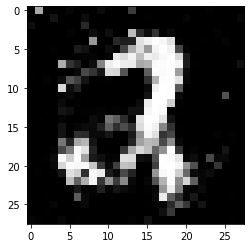

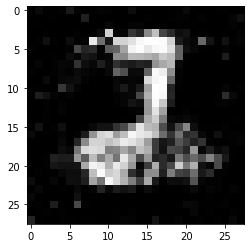

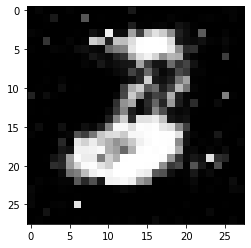

Epoch 31: D (0.3086684 real_err, 0.2051892 fake_err) G (-0.34474128 err);  time (4.3787312507629395)
Epoch 32: D (0.40813813 real_err, 0.20359327 fake_err) G (-0.19409718 err);  time (4.384692907333374)
Epoch 33: D (0.70643884 real_err, 0.24670257 fake_err) G (-0.2646358 err);  time (4.346733570098877)
Epoch 34: D (0.22251765 real_err, 0.2775924 fake_err) G (-0.33639988 err);  time (4.356685638427734)
Epoch 35: D (0.48774773 real_err, 0.21344703 fake_err) G (-0.2518612 err);  time (4.355763912200928)


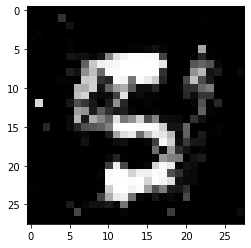

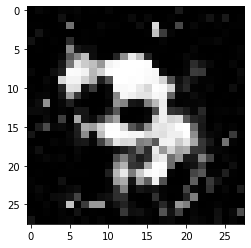

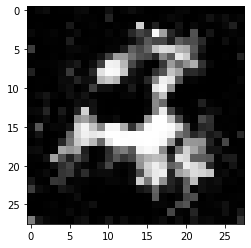

Epoch 36: D (0.5034908 real_err, 0.2717732 fake_err) G (-0.25480685 err);  time (4.378509998321533)
Epoch 37: D (0.49323863 real_err, 0.33925003 fake_err) G (-0.19972679 err);  time (4.348692178726196)
Epoch 38: D (0.16715243 real_err, 0.60466987 fake_err) G (-0.6661421 err);  time (4.35817551612854)
Epoch 39: D (0.4163984 real_err, 0.27212778 fake_err) G (-0.6330416 err);  time (4.364823818206787)
Epoch 40: D (0.41953018 real_err, 0.46594486 fake_err) G (-0.35188547 err);  time (4.3547563552856445)


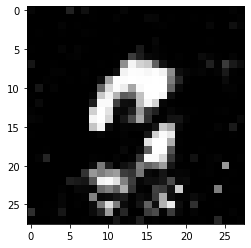

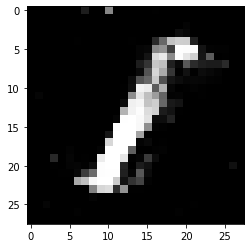

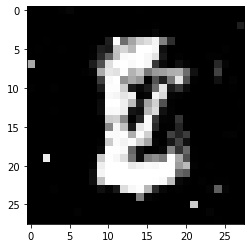

Epoch 41: D (0.3741394 real_err, 0.5342937 fake_err) G (-0.37540156 err);  time (4.361223220825195)
Epoch 42: D (0.21728285 real_err, 0.44732684 fake_err) G (-0.40999916 err);  time (4.367387294769287)
Epoch 43: D (0.39619544 real_err, 0.32203022 fake_err) G (-0.36019394 err);  time (4.3390867710113525)
Epoch 44: D (0.3742973 real_err, 0.4766496 fake_err) G (-0.40733588 err);  time (4.452161073684692)
Epoch 45: D (0.3247506 real_err, 0.5210715 fake_err) G (-0.45767215 err);  time (4.386667013168335)


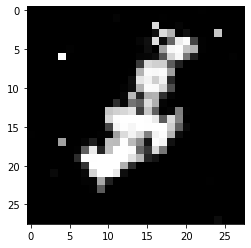

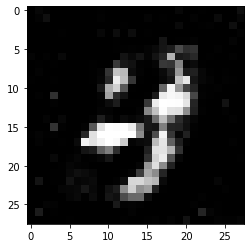

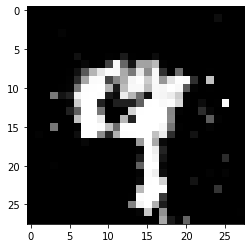

Epoch 46: D (0.36872748 real_err, 0.4964116 fake_err) G (-0.356684 err);  time (4.439844369888306)
Epoch 47: D (0.55917627 real_err, 0.27840313 fake_err) G (-0.47872454 err);  time (4.435827732086182)
Epoch 48: D (0.29826412 real_err, 0.39646482 fake_err) G (-0.40199828 err);  time (4.408117294311523)
Epoch 49: D (0.44030958 real_err, 0.47924688 fake_err) G (-0.35186824 err);  time (4.354733228683472)
Epoch 50: D (0.39850447 real_err, 0.45143852 fake_err) G (-0.43902826 err);  time (4.367810010910034)


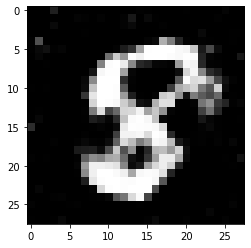

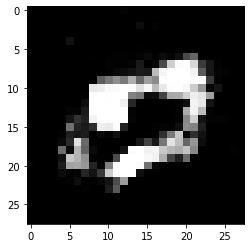

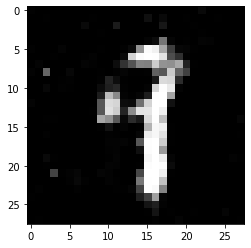

Epoch 51: D (0.43358386 real_err, 0.42878714 fake_err) G (-0.34099224 err);  time (4.341743469238281)
Epoch 52: D (0.43763733 real_err, 0.47437558 fake_err) G (-0.43158498 err);  time (4.363645076751709)
Epoch 53: D (0.40268263 real_err, 0.732144 fake_err) G (-0.62692845 err);  time (4.35181188583374)
Epoch 54: D (0.42188522 real_err, 0.5376779 fake_err) G (-0.4194319 err);  time (4.369116544723511)
Epoch 55: D (0.6041539 real_err, 0.37950918 fake_err) G (-0.35835496 err);  time (4.360873222351074)


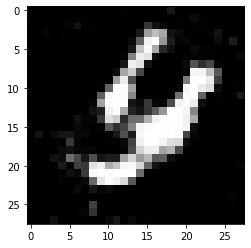

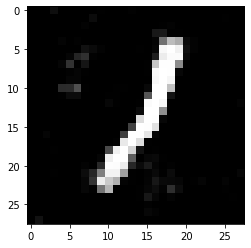

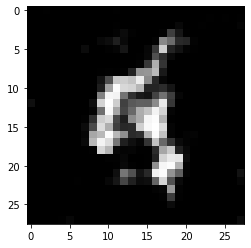

Epoch 56: D (0.58142763 real_err, 0.44476947 fake_err) G (-0.52313703 err);  time (4.354228734970093)
Epoch 57: D (0.39069474 real_err, 0.4952269 fake_err) G (-0.4668071 err);  time (4.357372522354126)
Epoch 58: D (0.49613723 real_err, 0.6282457 fake_err) G (-0.58023113 err);  time (4.365764379501343)
Epoch 59: D (0.71725833 real_err, 0.45703065 fake_err) G (-0.50960904 err);  time (4.3672449588775635)
Epoch 60: D (0.55230314 real_err, 0.43015957 fake_err) G (-0.30697086 err);  time (4.361409425735474)


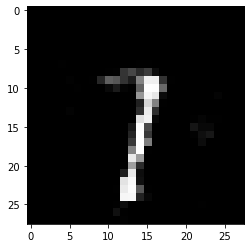

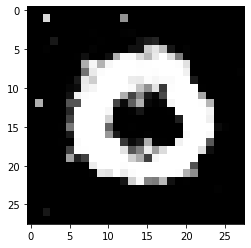

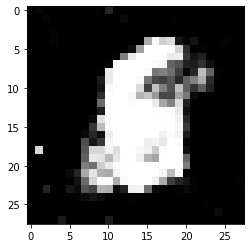

Epoch 61: D (0.44878381 real_err, 0.47220522 fake_err) G (-0.58437383 err);  time (4.3497045040130615)
Epoch 62: D (0.49398476 real_err, 0.52139527 fake_err) G (-0.5257651 err);  time (4.3607704639434814)
Epoch 63: D (0.4275434 real_err, 0.34908187 fake_err) G (-0.33622393 err);  time (4.363800287246704)
Epoch 64: D (0.50501615 real_err, 0.34731 fake_err) G (-0.32381988 err);  time (4.454779148101807)
Epoch 65: D (0.43595955 real_err, 0.45740923 fake_err) G (-0.4265196 err);  time (4.723808288574219)


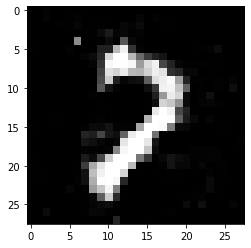

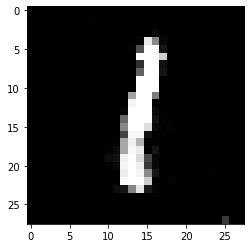

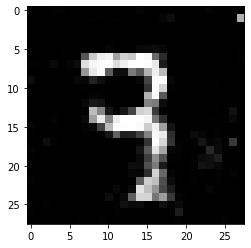

Epoch 66: D (0.36400238 real_err, 0.52771497 fake_err) G (-0.4669825 err);  time (4.619820594787598)
Epoch 67: D (0.34731475 real_err, 0.58983266 fake_err) G (-0.34998503 err);  time (4.4799346923828125)
Epoch 68: D (0.48497406 real_err, 0.44592667 fake_err) G (-0.36347312 err);  time (4.368769645690918)
Epoch 69: D (0.58481175 real_err, 0.6893972 fake_err) G (-0.52028954 err);  time (4.356823444366455)
Epoch 70: D (0.53235376 real_err, 0.35647747 fake_err) G (-0.42566326 err);  time (4.371649503707886)


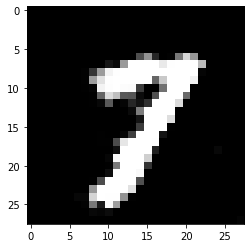

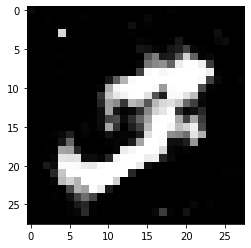

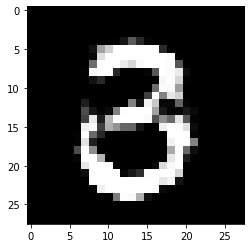

Epoch 71: D (0.57885903 real_err, 0.5284564 fake_err) G (-0.495161 err);  time (4.367062568664551)
Epoch 72: D (0.6043631 real_err, 0.4569271 fake_err) G (-0.5716396 err);  time (4.336719989776611)
Epoch 73: D (0.6220421 real_err, 0.43066788 fake_err) G (-0.4244026 err);  time (4.340336799621582)
Epoch 74: D (0.6597748 real_err, 0.37893835 fake_err) G (-0.43050238 err);  time (4.333000183105469)
Epoch 75: D (0.50184244 real_err, 0.49238303 fake_err) G (-0.59015965 err);  time (4.345577716827393)


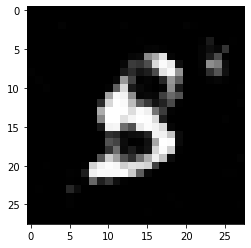

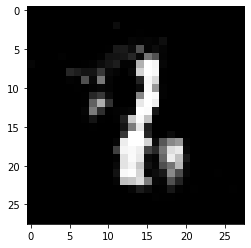

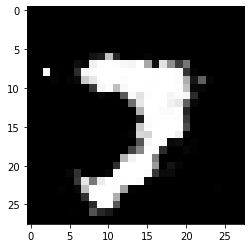

Epoch 76: D (0.5484648 real_err, 0.4460439 fake_err) G (-0.41815758 err);  time (4.3745276927948)
Epoch 77: D (0.64254606 real_err, 0.36970466 fake_err) G (-0.44201887 err);  time (4.383457183837891)
Epoch 78: D (0.49368346 real_err, 0.4237281 fake_err) G (-0.46422824 err);  time (4.352687358856201)
Epoch 79: D (0.5514271 real_err, 0.5011829 fake_err) G (-0.5380516 err);  time (4.348111867904663)
Epoch 80: D (0.5539594 real_err, 0.32869187 fake_err) G (-0.38524684 err);  time (4.387051820755005)


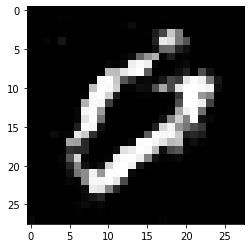

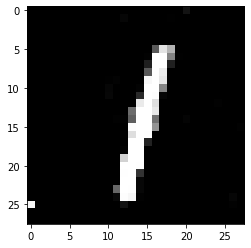

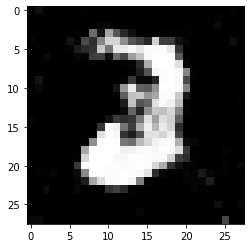

Epoch 81: D (0.50518197 real_err, 0.6175371 fake_err) G (-0.504624 err);  time (4.393101215362549)
Epoch 82: D (0.5188201 real_err, 0.5764257 fake_err) G (-0.55742073 err);  time (4.4447643756866455)
Epoch 83: D (0.4177065 real_err, 0.46729782 fake_err) G (-0.41193336 err);  time (4.44167160987854)
Epoch 84: D (0.3807416 real_err, 0.4164802 fake_err) G (-0.5327257 err);  time (4.379849433898926)
Epoch 85: D (0.52576977 real_err, 0.44588077 fake_err) G (-0.51359266 err);  time (4.37820839881897)


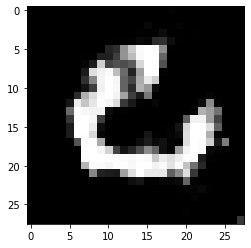

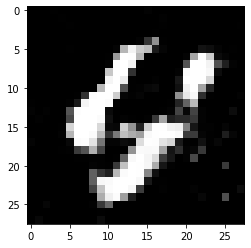

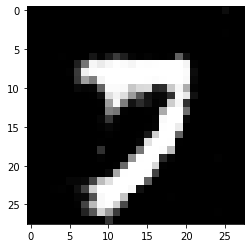

Epoch 86: D (0.40042245 real_err, 0.48569524 fake_err) G (-0.4567305 err);  time (4.372020959854126)
Epoch 87: D (0.45187795 real_err, 0.36153495 fake_err) G (-0.33982676 err);  time (4.360236883163452)
Epoch 88: D (0.5199442 real_err, 0.6584958 fake_err) G (-0.55559087 err);  time (4.342210292816162)
Epoch 89: D (0.5536195 real_err, 0.5462788 fake_err) G (-0.538694 err);  time (4.372956037521362)
Epoch 90: D (0.5415713 real_err, 0.5029522 fake_err) G (-0.44029713 err);  time (4.359025239944458)


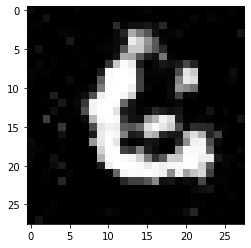

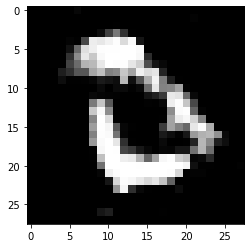

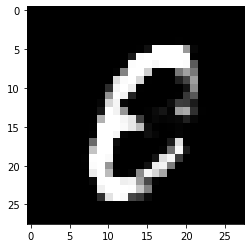

Epoch 91: D (0.52712584 real_err, 0.63522667 fake_err) G (-0.5597271 err);  time (4.3728814125061035)
Epoch 92: D (0.5088709 real_err, 0.6472225 fake_err) G (-0.60134876 err);  time (4.3517005443573)
Epoch 93: D (0.45730904 real_err, 0.46406302 fake_err) G (-0.3812657 err);  time (4.354032516479492)
Epoch 94: D (0.4812065 real_err, 0.6548727 fake_err) G (-0.61614513 err);  time (4.34838080406189)
Epoch 95: D (0.5265413 real_err, 0.5306117 fake_err) G (-0.5357128 err);  time (4.362712860107422)


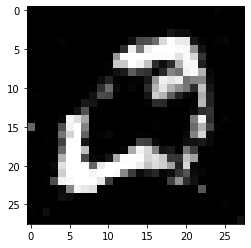

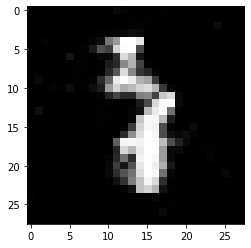

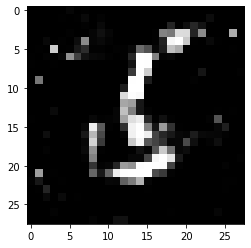

Epoch 96: D (0.4831218 real_err, 0.3893856 fake_err) G (-0.44702515 err);  time (4.348107099533081)
Epoch 97: D (0.53598714 real_err, 0.4732849 fake_err) G (-0.56238025 err);  time (4.3857643604278564)
Epoch 98: D (0.6824211 real_err, 0.52520967 fake_err) G (-0.5020444 err);  time (4.370038270950317)
Epoch 99: D (0.5122937 real_err, 0.35342216 fake_err) G (-0.32597214 err);  time (4.365430593490601)
Epoch 100: D (0.4550524 real_err, 0.49905667 fake_err) G (-0.54711074 err);  time (4.41931939125061)


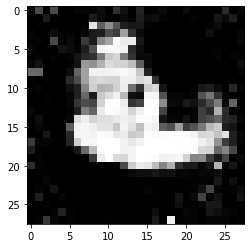

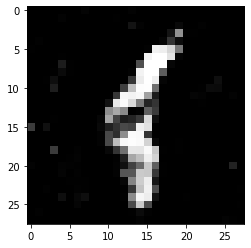

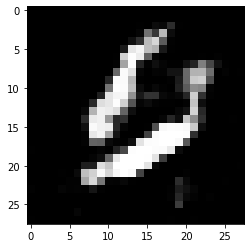

Epoch 101: D (0.5273018 real_err, 0.64628845 fake_err) G (-0.54348165 err);  time (4.42084264755249)
Epoch 102: D (0.7053392 real_err, 0.40650362 fake_err) G (-0.40600967 err);  time (4.37871241569519)
Epoch 103: D (0.64707005 real_err, 0.580176 fake_err) G (-0.5304143 err);  time (4.354687690734863)
Epoch 104: D (0.57576805 real_err, 0.45076677 fake_err) G (-0.48021987 err);  time (4.363905668258667)
Epoch 105: D (0.4347856 real_err, 0.78925323 fake_err) G (-0.6924635 err);  time (4.394680500030518)


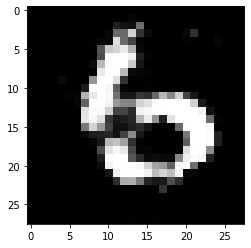

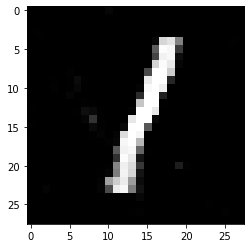

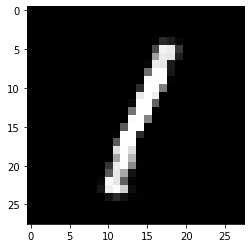

Epoch 106: D (0.3804608 real_err, 0.48562774 fake_err) G (-0.36956328 err);  time (4.347222089767456)
Epoch 107: D (0.5088736 real_err, 0.38653213 fake_err) G (-0.4954584 err);  time (4.3448545932769775)
Epoch 108: D (0.5850406 real_err, 0.42929503 fake_err) G (-0.4542974 err);  time (4.365311622619629)
Epoch 109: D (0.55069 real_err, 0.36820227 fake_err) G (-0.40853494 err);  time (4.33257794380188)
Epoch 110: D (0.68725866 real_err, 0.67413354 fake_err) G (-0.60204977 err);  time (4.339632034301758)


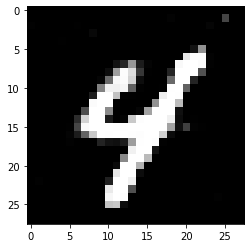

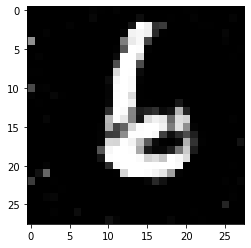

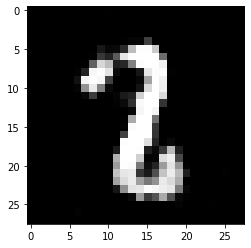

Epoch 111: D (0.47057596 real_err, 0.6119086 fake_err) G (-0.6786833 err);  time (4.364718198776245)
Epoch 112: D (0.4748003 real_err, 0.6611918 fake_err) G (-0.5730219 err);  time (4.3621721267700195)
Epoch 113: D (0.5237857 real_err, 0.58987635 fake_err) G (-0.52443355 err);  time (4.335299730300903)
Epoch 114: D (0.5334763 real_err, 0.6735326 fake_err) G (-0.6284915 err);  time (4.33701229095459)
Epoch 115: D (0.44276443 real_err, 0.5634985 fake_err) G (-0.52988356 err);  time (4.3584816455841064)


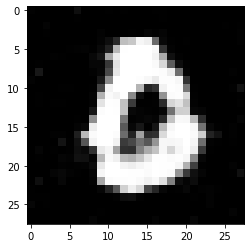

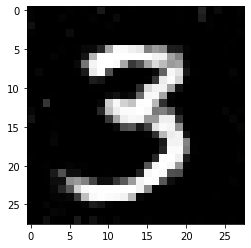

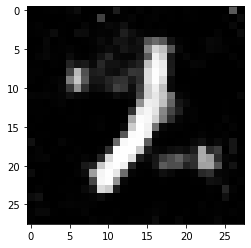

Epoch 116: D (0.53829557 real_err, 0.49028322 fake_err) G (-0.5569543 err);  time (4.331686735153198)
Epoch 117: D (0.48433065 real_err, 0.6732633 fake_err) G (-0.43362537 err);  time (4.383528470993042)
Epoch 118: D (0.48508826 real_err, 0.52369076 fake_err) G (-0.64662206 err);  time (4.434084177017212)
Epoch 119: D (0.71758014 real_err, 0.46387604 fake_err) G (-0.5541323 err);  time (4.485778570175171)
Epoch 120: D (0.52746314 real_err, 0.5659444 fake_err) G (-0.43782622 err);  time (4.367789030075073)


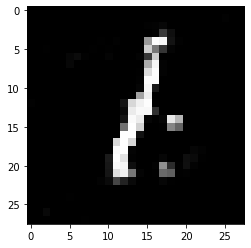

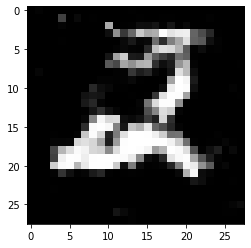

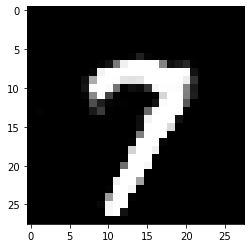

Epoch 121: D (0.6510847 real_err, 0.6088669 fake_err) G (-0.6085829 err);  time (4.391404390335083)
Epoch 122: D (0.7051985 real_err, 0.5443758 fake_err) G (-0.4750991 err);  time (4.354583740234375)
Epoch 123: D (0.59525055 real_err, 0.60915226 fake_err) G (-0.51108706 err);  time (4.365004301071167)
Epoch 124: D (0.62094283 real_err, 0.60852164 fake_err) G (-0.39735296 err);  time (4.358491897583008)
Epoch 125: D (0.5815797 real_err, 0.5275659 fake_err) G (-0.49910358 err);  time (4.3532874584198)


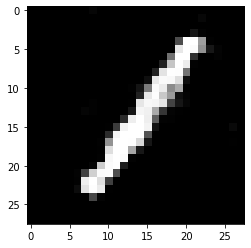

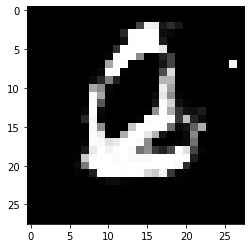

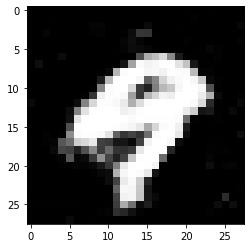

Epoch 126: D (0.52430135 real_err, 0.47407168 fake_err) G (-0.4754943 err);  time (4.374458312988281)
Epoch 127: D (0.46115848 real_err, 0.6493825 fake_err) G (-0.5078408 err);  time (4.343276262283325)
Epoch 128: D (0.44592762 real_err, 0.45940658 fake_err) G (-0.52383554 err);  time (4.355340480804443)
Epoch 129: D (0.41765773 real_err, 0.59683776 fake_err) G (-0.6479326 err);  time (4.341094493865967)
Epoch 130: D (0.6082849 real_err, 0.571533 fake_err) G (-0.55475295 err);  time (4.365220546722412)


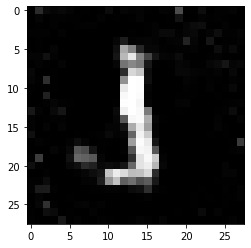

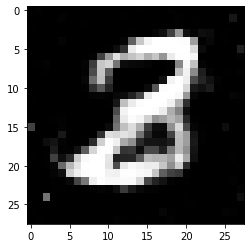

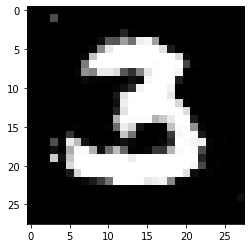

Epoch 131: D (0.6376379 real_err, 0.5089995 fake_err) G (-0.44847304 err);  time (4.406096935272217)
Epoch 132: D (0.4947198 real_err, 0.47534078 fake_err) G (-0.50341207 err);  time (4.343589544296265)
Epoch 133: D (0.667377 real_err, 0.5708915 fake_err) G (-0.553571 err);  time (4.43039345741272)
Epoch 134: D (0.64212215 real_err, 0.6585704 fake_err) G (-0.65506995 err);  time (4.515964984893799)
Epoch 135: D (0.5814399 real_err, 0.5611968 fake_err) G (-0.51520294 err);  time (4.670290946960449)


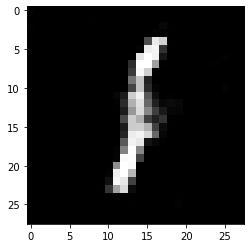

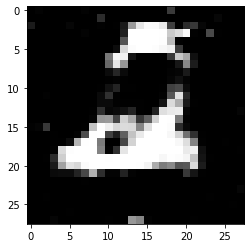

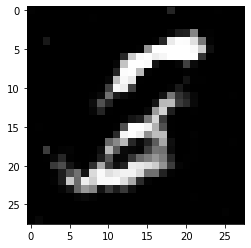

Epoch 136: D (0.5546244 real_err, 0.53289354 fake_err) G (-0.49073514 err);  time (4.664004325866699)
Epoch 137: D (0.5994034 real_err, 0.61206204 fake_err) G (-0.55692345 err);  time (4.484005928039551)
Epoch 138: D (0.5086994 real_err, 0.5079143 fake_err) G (-0.40937048 err);  time (4.378405809402466)
Epoch 139: D (0.60338104 real_err, 0.54101807 fake_err) G (-0.5216394 err);  time (4.366648435592651)
Epoch 140: D (0.55293435 real_err, 0.47547203 fake_err) G (-0.5143706 err);  time (4.364052057266235)


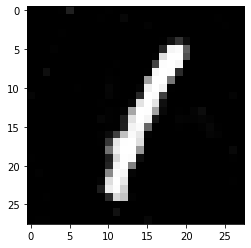

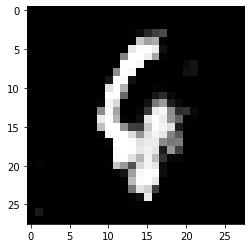

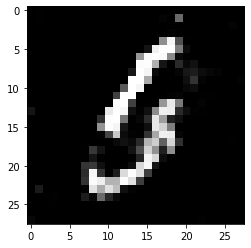

Epoch 141: D (0.68195236 real_err, 0.6452206 fake_err) G (-0.5494741 err);  time (4.364400386810303)
Epoch 142: D (0.5370418 real_err, 0.3486544 fake_err) G (-0.44232562 err);  time (4.350897789001465)
Epoch 143: D (0.44077408 real_err, 0.67082536 fake_err) G (-0.6250668 err);  time (4.386605262756348)
Epoch 144: D (0.6189884 real_err, 0.64401597 fake_err) G (-0.61257416 err);  time (4.361272096633911)
Epoch 145: D (0.52924347 real_err, 0.670672 fake_err) G (-0.674286 err);  time (4.375202417373657)


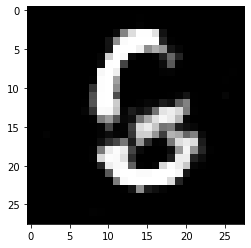

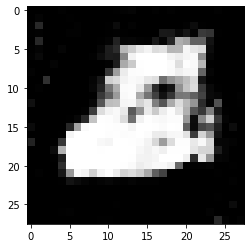

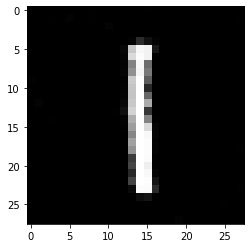

Epoch 146: D (0.6115604 real_err, 0.6715954 fake_err) G (-0.54508656 err);  time (4.356226921081543)
Epoch 147: D (0.5783856 real_err, 0.49838448 fake_err) G (-0.6039426 err);  time (4.374436616897583)
Epoch 148: D (0.5430698 real_err, 0.39612532 fake_err) G (-0.40067488 err);  time (4.338534116744995)
Epoch 149: D (0.5220422 real_err, 0.6479678 fake_err) G (-0.61373067 err);  time (4.376506328582764)
Epoch 150: D (0.5153544 real_err, 0.5985132 fake_err) G (-0.51619834 err);  time (4.3510377407073975)


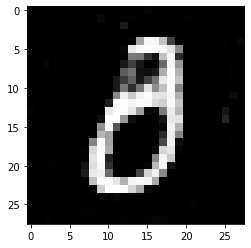

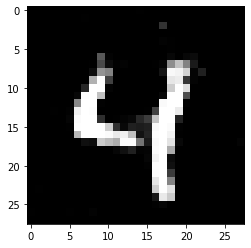

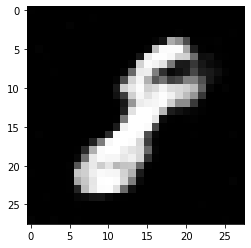

Epoch 151: D (0.49316368 real_err, 0.59154946 fake_err) G (-0.5568703 err);  time (4.405256509780884)
Epoch 152: D (0.5544433 real_err, 0.6681874 fake_err) G (-0.50479794 err);  time (4.365095853805542)
Epoch 153: D (0.5089235 real_err, 0.63578767 fake_err) G (-0.66401076 err);  time (4.367340087890625)
Epoch 154: D (0.45444492 real_err, 0.6989812 fake_err) G (-0.7596461 err);  time (4.420159816741943)
Epoch 155: D (0.5225541 real_err, 0.49188757 fake_err) G (-0.45987335 err);  time (4.409623622894287)


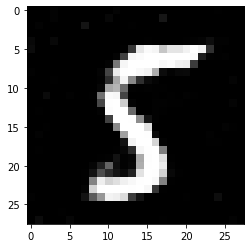

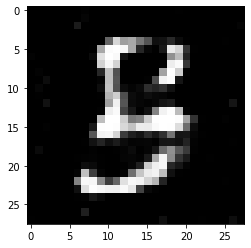

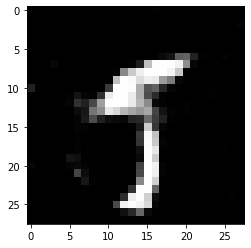

Epoch 156: D (0.5360241 real_err, 0.50918096 fake_err) G (-0.4634574 err);  time (4.384443283081055)
Epoch 157: D (0.54373777 real_err, 0.47348326 fake_err) G (-0.5556091 err);  time (4.362651348114014)
Epoch 158: D (0.4637969 real_err, 0.4279701 fake_err) G (-0.4864098 err);  time (4.388155460357666)
Epoch 159: D (0.7216757 real_err, 0.6028941 fake_err) G (-0.5279034 err);  time (4.354499578475952)
Epoch 160: D (0.517598 real_err, 0.6837083 fake_err) G (-0.688125 err);  time (4.367974281311035)


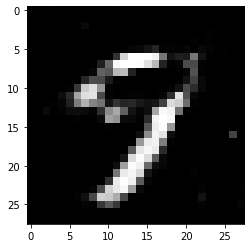

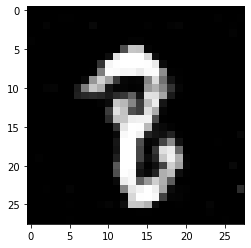

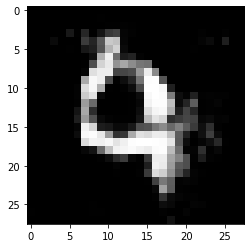

Epoch 161: D (0.5640461 real_err, 0.6667844 fake_err) G (-0.5148931 err);  time (4.361231088638306)
Epoch 162: D (0.58650154 real_err, 0.63358945 fake_err) G (-0.5223484 err);  time (4.370122194290161)
Epoch 163: D (0.56034863 real_err, 0.5258375 fake_err) G (-0.48263082 err);  time (4.339324235916138)
Epoch 164: D (0.53430855 real_err, 0.66253036 fake_err) G (-0.6896181 err);  time (4.360292434692383)
Epoch 165: D (0.6013688 real_err, 0.5675671 fake_err) G (-0.62843025 err);  time (4.347349405288696)


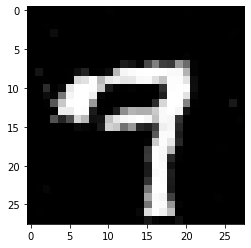

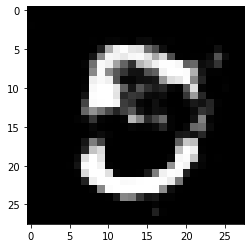

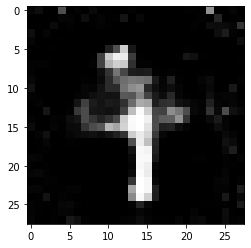

Epoch 166: D (0.54981625 real_err, 0.40155593 fake_err) G (-0.4833208 err);  time (4.369088649749756)
Epoch 167: D (0.56651306 real_err, 0.57492155 fake_err) G (-0.5028662 err);  time (4.360078573226929)
Epoch 168: D (0.43974745 real_err, 0.68934524 fake_err) G (-0.6887046 err);  time (4.3510518074035645)
Epoch 169: D (0.41787764 real_err, 0.62172264 fake_err) G (-0.58494794 err);  time (4.3486363887786865)
Epoch 170: D (0.5392464 real_err, 0.6849512 fake_err) G (-0.5773539 err);  time (4.353720188140869)


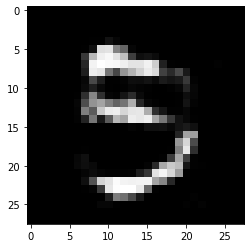

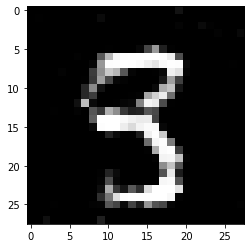

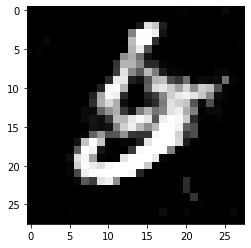

Epoch 171: D (0.67464006 real_err, 0.46519148 fake_err) G (-0.65192974 err);  time (4.3929572105407715)
Epoch 172: D (0.5764743 real_err, 0.5776364 fake_err) G (-0.518907 err);  time (4.401885271072388)
Epoch 173: D (0.56520414 real_err, 0.693623 fake_err) G (-0.7043995 err);  time (4.416241884231567)
Epoch 174: D (0.6258764 real_err, 0.5092761 fake_err) G (-0.534899 err);  time (4.395230293273926)
Epoch 175: D (0.5557872 real_err, 0.44563144 fake_err) G (-0.4840303 err);  time (4.367525577545166)


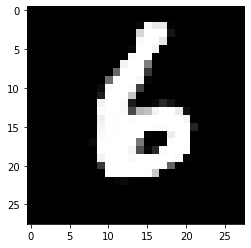

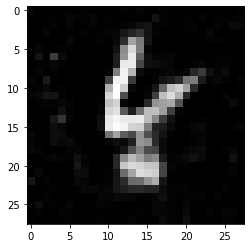

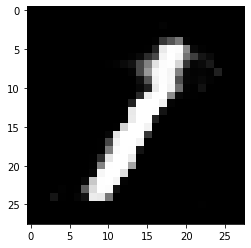

Epoch 176: D (0.44941798 real_err, 0.48824164 fake_err) G (-0.5570964 err);  time (4.368170976638794)
Epoch 177: D (0.43080512 real_err, 0.41121423 fake_err) G (-0.4668228 err);  time (4.352632999420166)
Epoch 178: D (0.45165852 real_err, 0.51550364 fake_err) G (-0.59097916 err);  time (4.366734027862549)
Epoch 179: D (0.62432754 real_err, 0.5863061 fake_err) G (-0.57243943 err);  time (4.391645431518555)
Epoch 180: D (0.59488624 real_err, 0.5323847 fake_err) G (-0.549892 err);  time (4.35348105430603)


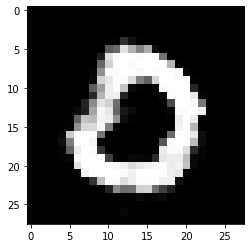

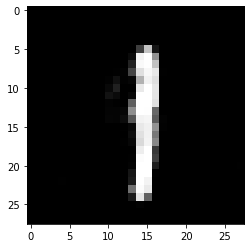

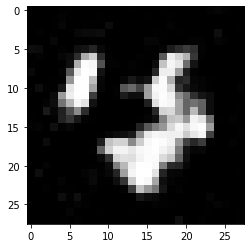

Epoch 181: D (0.57439464 real_err, 0.63486713 fake_err) G (-0.669004 err);  time (4.3531975746154785)
Epoch 182: D (0.47568 real_err, 0.4724912 fake_err) G (-0.46169117 err);  time (4.390428304672241)
Epoch 183: D (0.5235667 real_err, 0.76484996 fake_err) G (-0.57270455 err);  time (4.3374574184417725)
Epoch 184: D (0.7717619 real_err, 0.54141515 fake_err) G (-0.57111925 err);  time (4.349389314651489)
Epoch 185: D (0.5967172 real_err, 0.5083029 fake_err) G (-0.5113988 err);  time (4.378705024719238)


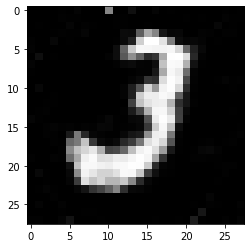

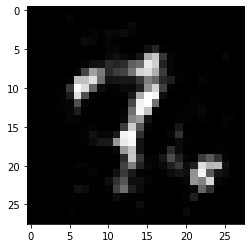

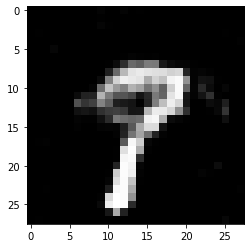

Epoch 186: D (0.55151546 real_err, 0.6065652 fake_err) G (-0.55816936 err);  time (4.3584818840026855)
Epoch 187: D (0.5296236 real_err, 0.54175603 fake_err) G (-0.55031055 err);  time (4.336106777191162)
Epoch 188: D (0.57651323 real_err, 0.560112 fake_err) G (-0.53105557 err);  time (4.391564607620239)
Epoch 189: D (0.51648754 real_err, 0.5185088 fake_err) G (-0.49830922 err);  time (4.382837295532227)
Epoch 190: D (0.44903663 real_err, 0.47874314 fake_err) G (-0.58942205 err);  time (4.3954572677612305)


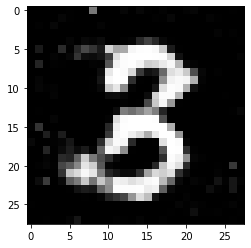

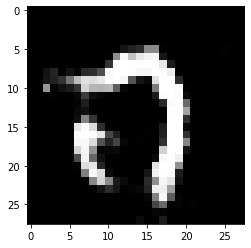

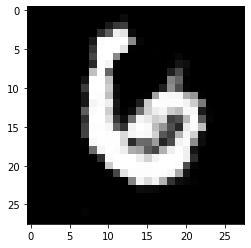

Epoch 191: D (0.5755423 real_err, 0.58651716 fake_err) G (-0.6615286 err);  time (4.41864800453186)
Epoch 192: D (0.5183564 real_err, 0.46413547 fake_err) G (-0.58348995 err);  time (4.437880277633667)
Epoch 193: D (0.57324696 real_err, 0.5911675 fake_err) G (-0.59272516 err);  time (4.3751914501190186)
Epoch 194: D (0.5513121 real_err, 0.4836739 fake_err) G (-0.38417497 err);  time (4.351746082305908)
Epoch 195: D (0.454581 real_err, 0.5744584 fake_err) G (-0.61126316 err);  time (4.348861217498779)


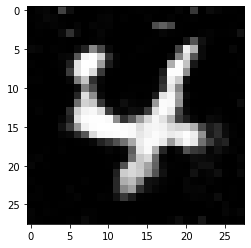

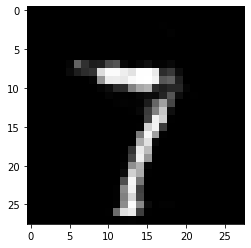

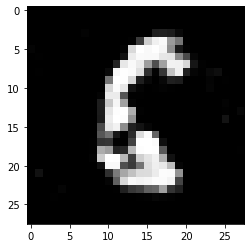

Epoch 196: D (0.6192616 real_err, 0.36132437 fake_err) G (-0.47283295 err);  time (4.375369548797607)
Epoch 197: D (0.43173495 real_err, 0.55518454 fake_err) G (-0.56097335 err);  time (4.3654937744140625)
Epoch 198: D (0.49583519 real_err, 0.51388747 fake_err) G (-0.45726013 err);  time (4.372918367385864)
Epoch 199: D (0.5033438 real_err, 0.4763535 fake_err) G (-0.39140186 err);  time (4.362191915512085)


In [0]:
gan.train(200)

In [0]:
samples = gan.sample_data(10)*0.5 + 0.5

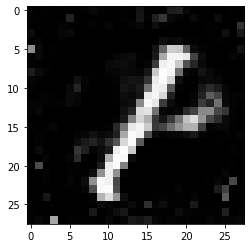

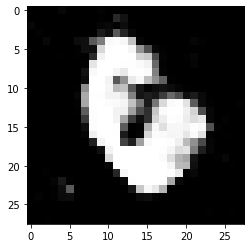

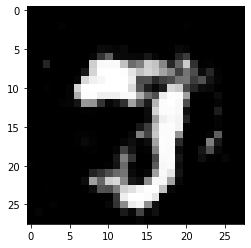

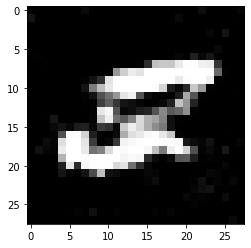

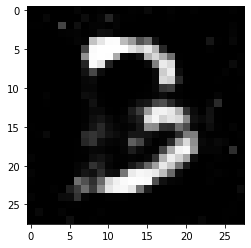

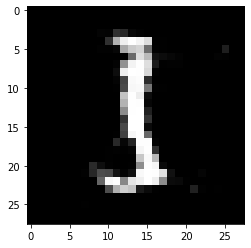

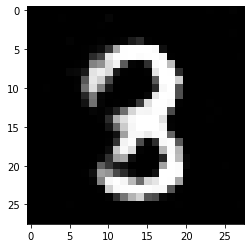

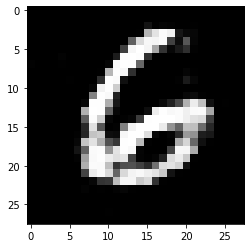

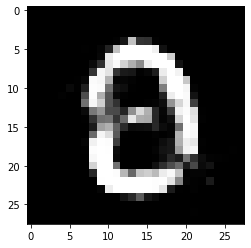

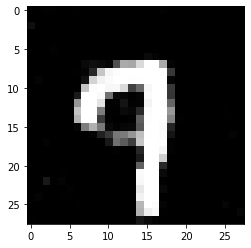

In [0]:
for img in samples:
    plt.figure()
    plt.imshow(img[:,:,0], cmap='gray')
    plt.show()